# Naive Bayes classifier for Amazon fine food reviews for Bag of words and tf-idf

### The objective

Given a text review, we have to predict whether the review represents positove sentiment or negative.
In other words, we ahve to classify the review as 'Positive' or 'Negative'.
We will use the Amazon fine food review dataset from Kaggle.com

https://www.kaggle.com/snap/amazon-fine-food-reviews
    
### Context

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

### Contents

    Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
    database.sqlite: Contains the table 'Reviews'

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews    

In this notebook, we will use MultinomialNB and BernoulliNB classifiers on BoW and Tf-Idf vectorizers on Text column. We will also check if adding additional feature like length of text helps in improving the performance.

First, import all required libraries


In [1]:
%%time
%matplotlib inline
from datetime import datetime
import sqlite3
from sklearn.metrics import roc_curve, auc,roc_auc_score
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings('ignore')
import gensim
print('Done')

Done
Wall time: 12.3 s


#### Function to print confusion matrix and classification report

In [2]:
from prettytable import PrettyTable
#source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,6), fontsize=10):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
def print_classif_report(input_dict):
    tab = PrettyTable()
    tab.field_names = ["Label","Precision","Recall","f1-Score","Support"]
    list1=[]
    for k,v in input_dict.items():
        list1=[]
        list1.append(k)
        for i,j in v.items():
            list1.append("{0:.2f}".format(j))
        
        tab.add_row(list1)
    print(tab)    

#### function to get important features for given classifier and vectorizer

In [3]:

def most_informative_feature(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]

    print('Negative class')
    
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print(' ************************************* ')
    print('Positive class')

    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)


### function to return column of text lengths

In [4]:
def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

### Read the data from SQLite file

Read the data from database.
We will not consider 3 star reviews as they are neutral (neither completely positive nor negative)

In [6]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 as they are neutral

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

#Function to map reviews with Score>3 to a positive rating, and reviews with a score<3 to a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition)

Check sample data

In [7]:
filtered_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


Sort the data by productid

In [8]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Remove duplicates

In [9]:
#Remove duplicate reviews by same user at same time
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Remove rows where helpfulness denominator is greater than helpfulness numerator

In [10]:
#Keep only those records where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

Function to clean the sentences.
The function will remove html tags and punctuation marks from the input text and return cleaned text.

In [11]:
import re
import string
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleansentence(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',cleantext)
    cleantext = re.sub(r'[.|,|)|(|\|/|-|+|;|&]',r' ',cleantext)
    return  cleantext


Sort by time for time based splitting

In [12]:
sample=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Cleaning the review text by using above written function.
Also performing the stemming procedure to reduce the words to their base stem forms.
Cleaned text will be stored in separate column.
For tf-idf weighted word2vec, we are storing non-stemmed clean review text in another column.

In [13]:
i=0
str1=' '
str2=' '
final_string=[]
final_string_2=[]
s=''
s1=''
for sent in sample['Text'].values:
    filtered_sentence=[]
    filtered_nostem = []
    #print(sent);
    sent=cleansentence(sent) # remove HTMl tags
    for w in sent.split():
        if((w.isalpha()) & (len(w)>2)):    
                if(w.lower() not in stop):
                    s=(sno.stem(w.lower())).encode('utf8')
                    s1 = (w.lower()).encode('utf8')
                    filtered_sentence.append(s)
                    filtered_nostem.append(s1)
                    
                else:
                    continue
        else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    str2 = b" ".join(filtered_nostem) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    final_string_2.append(str2)
    i+=1

In [14]:
#adding a column  which displays the data after pre-processing of the review 
sample['CleanedText']=final_string
sample['CleanedTextNoStem']=final_string_2

Save the cleaned text in a file for use later

In [15]:
#pickle.dump(sample,open('cleaned_final.p','wb'))
pd.to_pickle(sample,'cleaned_Text.pkl')

In [5]:
testdf=pd.read_pickle('cleaned_Text.pkl')

In [6]:
testdf.shape
sample=testdf

In [7]:
#sample.head(1)
sample.head(1)
#sample['Score'].value_counts()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedTextNoStem
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...


### First using Bag of Words vectorizer

In [8]:
#sort by time for time based splitting
sample=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sample['CleanedText'].values,sample['Score'].values,test_size=0.2,shuffle=False)


### MultinomialNB for bag of words

The Sklearn documentation for MultinomialNB reads:

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

So, we will use MultinomialNB for the BoW and Tf-Idf vectorizers

best parameter alpha {'alpha': 0.001}
AUC score:  0.72
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.83   |  0.46  |   0.59   | 12535.00 |
|      1       |    0.90   |  0.98  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.86   |  0.72  |   0.76   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


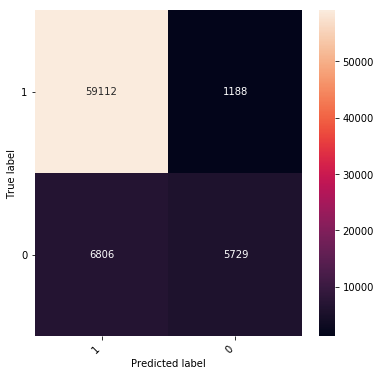

In [10]:
#Using bigrams
count_vect = CountVectorizer(ngram_range=(1,2))
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_test =  count_vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')
paramsearch.fit(bag_of_words_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(bag_of_words_test)

bow_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [11]:
most_informative_feature(count_vect, paramsearch.best_estimator_)

Negative class
0 -4.8800468976267375 tast
0 -4.963816425464492 like
0 -5.135649424250467 product
0 -5.412449914016955 one
0 -5.442095175249078 flavor
0 -5.558829135172392 would
0 -5.5632713575348856 tri
0 -5.726728443905287 good
0 -5.744043046165492 coffe
0 -5.753204734348433 use
 ************************************* 
Positive class
1 -5.11142243986591 like
1 -5.177334492768708 tast
1 -5.318387223915307 good
1 -5.334507627151305 flavor
1 -5.373109914261352 love
1 -5.39908355854879 great
1 -5.4157182172197995 use
1 -5.469133066293436 one
1 -5.5543961705764495 product
1 -5.576337167488662 tea


best parameter alpha {'alpha': 0.1}
AUC score:  0.82
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.68   |  0.71  |   0.69   | 12535.00 |
|      1       |    0.94   |  0.93  |   0.93   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.81   |  0.82  |   0.81   | 72835.00 |
| weighted avg |    0.89   |  0.89  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


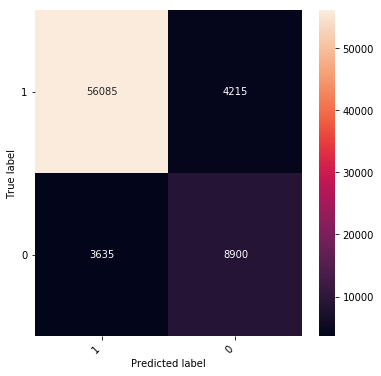

In [12]:
# Unigrams only
count_vect = CountVectorizer()
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_test =  count_vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')
paramsearch.fit(bag_of_words_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(bag_of_words_test)

bow_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [13]:
most_informative_feature(count_vect, paramsearch.best_estimator_)

Negative class
0 -4.201883950621312 tast
0 -4.28565316477685 like
0 -4.45748543171506 product
0 -4.734284443219311 one
0 -4.7639295204955285 flavor
0 -4.880662700639093 would
0 -4.885104891492071 tri
0 -5.048560715492096 good
0 -5.065875171544221 coffe
0 -5.075036781333731 use
 ************************************* 
Positive class
1 -4.432087704503532 like
1 -4.4979996968417435 tast
1 -4.6390522841553405 good
1 -4.655172669623797 flavor
1 -4.693774913004837 love
1 -4.719748526904619 great
1 -4.7363831656953135 use
1 -4.789797948649529 one
1 -4.875060939791135 product
1 -4.897001905993831 tea


### BernoulliNB for BoW with binary = True

The sklearn documentation for BernoulliNB reads: 
BernoulliNB is designed for binary/boolean features

So, we will use the BernoulliNB classifier for the Bow using binary = True

AUC score: 0.7
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.87   |  0.41  |   0.55   | 12535.00 |
|      1       |    0.89   |  0.99  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.88   |  0.70  |   0.74   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.87   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


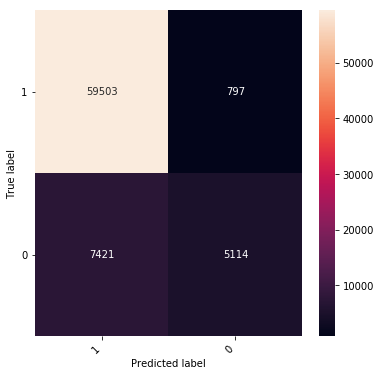

In [14]:
#including bigrams
classifier = Pipeline([
    ('Vectorizer', CountVectorizer(ngram_range=(1,2),binary=True)),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.79
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.67   |  0.65  |   0.66   | 12535.00 |
|      1       |    0.93   |  0.93  |   0.93   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.80   |  0.79  |   0.80   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


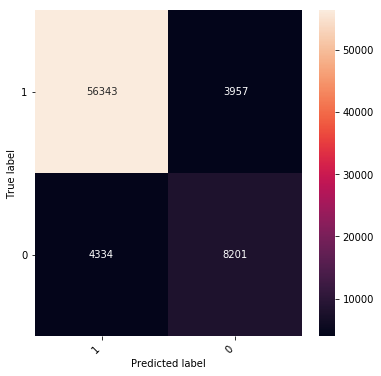

In [15]:
#including unigrams only
classifier = Pipeline([
    ('Vectorizer', CountVectorizer(binary=True)),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### MultinomialNB for BoW including summary length as another feature

AUC score: 0.82
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.68   |  0.71  |   0.69   | 12535.00 |
|      1       |    0.94   |  0.93  |   0.93   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.81   |  0.82  |   0.81   | 72835.00 |
| weighted avg |    0.89   |  0.89  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


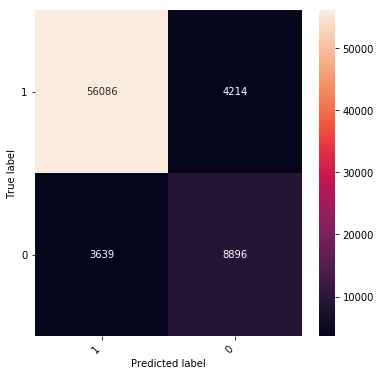

In [16]:
#including summary length as another feature with unigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer()),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.72
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.83   |  0.46  |   0.59   | 12535.00 |
|      1       |    0.90   |  0.98  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.86   |  0.72  |   0.76   | 72835.00 |
| weighted avg |    0.89   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


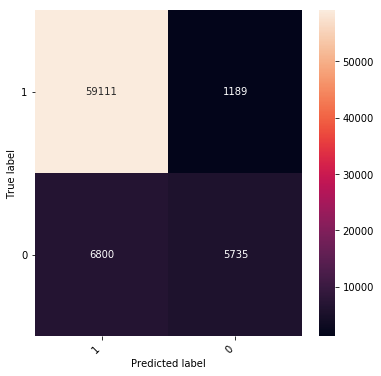

In [17]:
#including summary length as another feature with unigram/bigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(ngram_range=(1,2))),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### BernoulliNB for BoW including summary length

AUC score: 0.79
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.67   |  0.65  |   0.66   | 12535.00 |
|      1       |    0.93   |  0.93  |   0.93   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.80   |  0.79  |   0.80   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


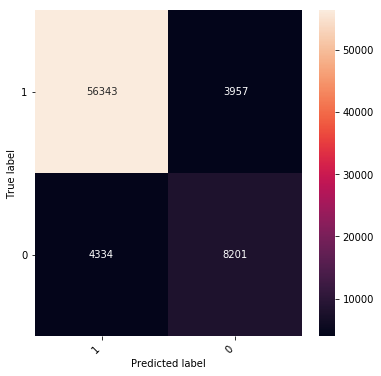

In [18]:
#including summary length as another feature with unigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(binary=True)),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.7
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.87   |  0.41  |   0.55   | 12535.00 |
|      1       |    0.89   |  0.99  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.88   |  0.70  |   0.74   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.87   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


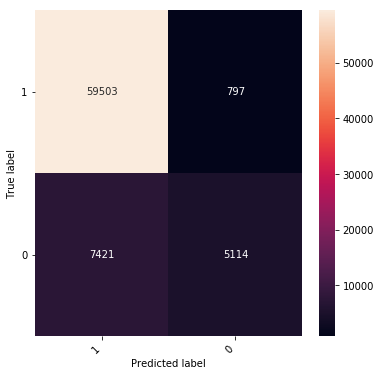

In [19]:
#including summary length as another feature with bigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(binary=True,ngram_range=(1,2))),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### Summary for BoW vectorizer

In [33]:
tab = PrettyTable()
tab.field_names = ["Classifier","Ngram_range","Length included Y/N","AUC"]
list1=["MultinomialNB","1","N","0.82"]
list2=["MultinomialNB","1,2","N","0.72"]
list3=["BernoulliNB","1","N","0.79"]
list4=["BernoulliNB","1,2","N","0.70"]
list5=["MultinomialNB","1","Y","0.82"]
list6=["MultinomialNB","1,2","Y","0.72"]
list7=["BernoulliNB","1","Y","0.79"]
list8=["BernoulliNB","1,2","Y","0.70"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
tab.add_row(list5)
tab.add_row(list6)
tab.add_row(list7)
tab.add_row(list8)
print(tab) 

+---------------+-------------+---------------------+------+
|   Classifier  | Ngram_range | Length included Y/N | AUC  |
+---------------+-------------+---------------------+------+
| MultinomialNB |      1      |          N          | 0.82 |
| MultinomialNB |     1,2     |          N          | 0.72 |
|  BernoulliNB  |      1      |          N          | 0.79 |
|  BernoulliNB  |     1,2     |          N          | 0.70 |
| MultinomialNB |      1      |          Y          | 0.82 |
| MultinomialNB |     1,2     |          Y          | 0.72 |
|  BernoulliNB  |      1      |          Y          | 0.79 |
|  BernoulliNB  |     1,2     |          Y          | 0.70 |
+---------------+-------------+---------------------+------+


## Using TF-IDF Vectorizer

### MultinomialNB for Tf-Idf

best parameter alpha {'alpha': 0.01}
AUC score:  0.7
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.89   |  0.45  |   0.59   | 12535.00 |
|      1       |    0.90   |  0.99  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.89   |  0.72  |   0.77   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


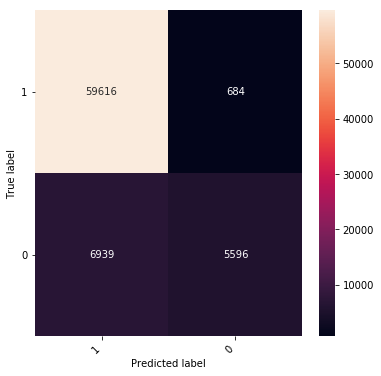

In [20]:
#Using bigrams
vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = vect.fit_transform(x_train)
tfidf_test =  vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')
paramsearch.fit(tfidf_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(tfidf_test)

tfidf_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [21]:
most_informative_feature(vect, paramsearch.best_estimator_)

Negative class
0 -6.040811706230108 tast
0 -6.1868466490712 like
0 -6.235187611057945 product
0 -6.5303156967672855 would
0 -6.543245784093453 flavor
0 -6.550234137932577 coffe
0 -6.573393375897642 one
0 -6.676125538980858 tri
0 -6.701801620583285 buy
0 -6.714604691431835 order
 ************************************* 
Positive class
1 -6.233458549105974 great
1 -6.240166090909289 love
1 -6.283343936586439 tast
1 -6.294478604170486 like
1 -6.296617275202786 good
1 -6.30330458512822 tea
1 -6.352944767303246 flavor
1 -6.377572180663797 coffe
1 -6.465435544130965 use
1 -6.4731957412418435 product


best parameter alpha {'alpha': 0.01}
AUC score:  0.7
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.86   |  0.27  |   0.41   | 12535.00 |
|      1       |    0.87   |  0.99  |   0.92   | 60300.00 |
|  micro avg   |    0.87   |  0.87  |   0.87   | 72835.00 |
|  macro avg   |    0.86   |  0.63  |   0.67   | 72835.00 |
| weighted avg |    0.87   |  0.87  |   0.84   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


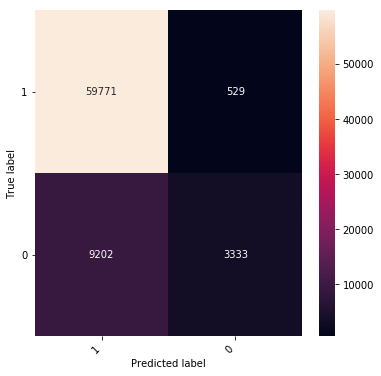

In [22]:
#Using unigrams only
vect = TfidfVectorizer()
tfidf_train = vect.fit_transform(x_train)
tfidf_test =  vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')
paramsearch.fit(tfidf_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(tfidf_test)

tfidf_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [23]:
most_informative_feature(vect, paramsearch.best_estimator_)

Negative class
0 -4.827700924440859 tast
0 -4.98304311269626 like
0 -5.032820414074225 product
0 -5.324277885474799 would
0 -5.33804821537005 flavor
0 -5.35029882505596 coffe
0 -5.373064008992803 one
0 -5.468950594973154 tri
0 -5.488037157354664 buy
0 -5.5072206776964 order
 ************************************* 
Positive class
1 -5.066326748583313 great
1 -5.078040832276059 love
1 -5.13624816661096 tast
1 -5.138636007571398 good
1 -5.155970540844006 like
1 -5.1853722526811765 tea
1 -5.208311211159984 flavor
1 -5.238632195756493 coffe
1 -5.315379685926004 product
1 -5.332929626037677 use


### MultinomialNB for Tf-Idf with summary length as additional feature

AUC score: 0.72
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.89   |  0.45  |   0.59   | 12535.00 |
|      1       |    0.90   |  0.99  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.89   |  0.72  |   0.77   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


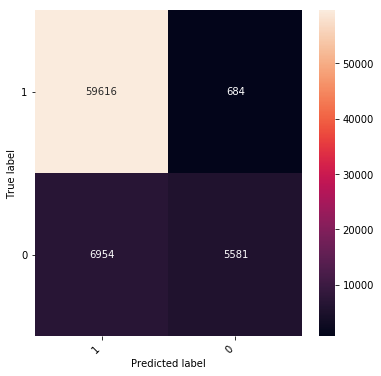

In [24]:
#including summary length as another feature with bigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', TfidfVectorizer(ngram_range=(1,2))),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.63
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.83   |  0.27  |   0.40   | 12535.00 |
|      1       |    0.87   |  0.99  |   0.92   | 60300.00 |
|  micro avg   |    0.86   |  0.86  |   0.86   | 72835.00 |
|  macro avg   |    0.85   |  0.63  |   0.66   | 72835.00 |
| weighted avg |    0.86   |  0.86  |   0.83   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


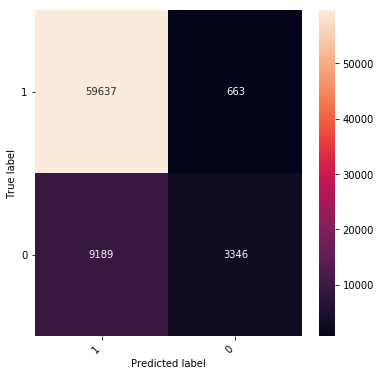

In [25]:
#including summary length as another feature with unigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', TfidfVectorizer()),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=-1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### Summary for Tf-Idf vectorizer

In [40]:
tab = PrettyTable()
tab.field_names = ["Classifier","Ngram_range","Length included Y/N","AUC"]
list1=["MultinomialNB","1","N","0.70"]
list2=["MultinomialNB","1,2","N","0.70"]
list3=["MultinomialNB","1","Y","0.72"]
list4=["MultinomialNB","1,2","Y","0.63"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
print(tab) 

+---------------+-------------+---------------------+------+
|   Classifier  | Ngram_range | Length included Y/N | AUC  |
+---------------+-------------+---------------------+------+
| MultinomialNB |      1      |          N          | 0.70 |
| MultinomialNB |     1,2     |          N          | 0.70 |
| MultinomialNB |      1      |          Y          | 0.72 |
| MultinomialNB |     1,2     |          Y          | 0.63 |
+---------------+-------------+---------------------+------+
